In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch

from transformers import GPT2Tokenizer, GPT2LMHeadModel

from utils.analysis import center_of_mass_vector, PCA
from utils.retrieval import get_activations, get_all_embedded_vectors
from utils.visualization import visualize_particle_evolution

2025-05-18 09:10:33.539225: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 09:10:33.562457: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpt2_version = "openai-community/gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(gpt2_version)
model = GPT2LMHeadModel.from_pretrained(gpt2_version)

In [3]:
# constants of the model
TOTAL_VOCAB_SIZE = tokenizer.vocab_size
MAXIMUM_INPUT_LENGTH = 1024
N_BLOCKS = 12

In [4]:
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [5]:
n_tokens = 100
input_ids = torch.randint(0, TOTAL_VOCAB_SIZE, size = (1, n_tokens))
activations = get_activations(model)

with torch.no_grad():
    output = model(input_ids, output_attentions = True)

for att in output.attentions:
    activations["attn_attentions"].append(att[0])

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [6]:
def plot_eigvals_dist(eigvals, pca_eigvals, l):
    variance = np.prod(eigvals**(1/len(eigvals))) * np.sqrt(1 + l)
    l_plus = (1 + np.sqrt(l))**2 * variance
    l_minus = (1 - np.sqrt(l))**2 * variance
    x = np.linspace(l_minus, l_plus, 1000)

    def marchenko_pastur(x):
        return np.sqrt((l_plus - x) * (x - l_minus)) / (2 * np.pi * x * l * variance)

    fig, ax = plt.subplots()
    ax.hist(pca_eigvals, bins = len(eigvals), density=True)
    ax.plot(x, marchenko_pastur(x))
    fig.tight_layout()
    plt.show()
    return

In [7]:
def compute_dimentionality(model, n_inputs: int, input_length: int, tracked_activations: list, method: str):
    # generate random input token ids
    input_ids = torch.randint(0, TOTAL_VOCAB_SIZE, size = (n_inputs, input_length))
    # initialize activations dictionary
    activations = get_activations(model)
    n_activations = len(tracked_activations)

    # initialize array to store the intrinsic dimentionality of all activations tracked
    dimentionality = np.zeros(shape = (n_inputs, n_activations, N_BLOCKS))
    # array to store how much info is retained after pca
    information_retain = np.zeros(shape = (n_inputs, n_activations, N_BLOCKS))
    for i, ids in enumerate(input_ids):
        # running the model
        with torch.no_grad():
            output = model(ids)
        # computing intrinsic dimentionality via PCA 
        for j, act in enumerate(tracked_activations):
            for k in range(N_BLOCKS):
                pca = PCA(method=method).fit(activations[act][k])
                dim = pca.explained_variance_.shape[0]
                dimentionality[i,j,k] = dim
                information_retain[i,j,k] = (torch.sum(pca.explained_variance_) / torch.sum(pca.eigenvalues) ).detach().numpy()
        # resetting activation dictionary
        for key in activations:
            activations[key] = []

    return dimentionality, information_retain

In [8]:
n_inputs = 100
input_length = 50
tracked_activations = [
    "ln_1_inputs",
    "ln_1_outputs",
    "attn_outputs",
    "ln_2_inputs",
    "ln_2_outputs",
    "mlp_outputs"
]
method = "marchenko_pastur_cutoff"
dimentionality, information_retain = compute_dimentionality(model, n_inputs, input_length, tracked_activations, method)

In [9]:
def plot_block_dimentionality(dimentionality: np.ndarray, tracked_activations: list):
    fig, axs = plt.subplots(nrows=N_BLOCKS, figsize = (5, 3 * N_BLOCKS))
    
    dim_mean = np.mean(dimentionality, axis = 0)
    dim_std = np.std(dimentionality, axis = 0)

    dim_max = np.max(dim_mean + 2 * dim_std)
    dim_min = np.min(dim_mean - 2 * dim_std)

    for k in range(N_BLOCKS):
        axs[k].grid(axis = "y", alpha = 0.5)
        axs[k].errorbar(x = np.arange(len(tracked_activations)), y = dim_mean[:,k], yerr = dim_std[:,k], 
                        fmt = "o-", capsize = 2, elinewidth = 1, linewidth = 1)
        axs[k].set_ylabel(f"Block {k+1}")
        axs[k].set_ylim(dim_min, dim_max)

        if k < N_BLOCKS - 1:
            axs[k].set_xticks([])
        else:
            axs[k].set_xticks(np.arange(len(tracked_activations)))
            axs[k].set_xticklabels(tracked_activations, rotation = 90)
            
    fig.tight_layout()
    plt.show()
    return

In [18]:
def plot_block_information_retain(information_retain: np.ndarray, tracked_activations: list):
    fig, axs = plt.subplots(nrows=N_BLOCKS, figsize = (5, 3 * N_BLOCKS))
    
    info_mean = np.mean(information_retain, axis = 0)
    info_std = np.std(information_retain, axis = 0)

    for k in range(N_BLOCKS):
        axs[k].grid(axis = "y", alpha = 0.5)
        axs[k].errorbar(x = np.arange(len(tracked_activations)), y = info_mean[:,k], yerr = info_std[:,k], 
                        fmt = "o-", capsize = 2, elinewidth = 1, linewidth = 1)
        axs[k].set_ylabel(f"Block {k+1}")
        axs[k].set_ylim(0, 1)

        if k < N_BLOCKS - 1:
            axs[k].set_xticks([])
        else:
            axs[k].set_xticks(np.arange(len(tracked_activations)))
            axs[k].set_xticklabels(tracked_activations, rotation = 90)
            
    fig.tight_layout()
    plt.show()
    return

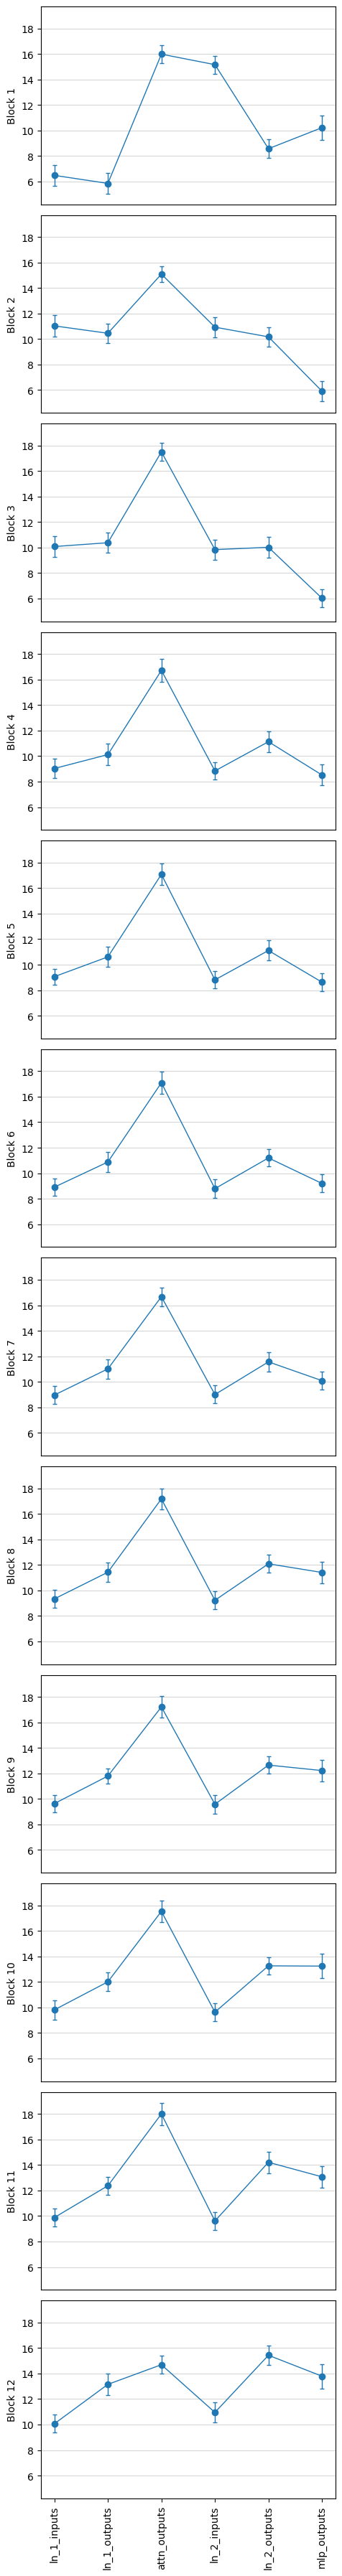

In [10]:
plot_block_dimentionality(dimentionality, tracked_activations)

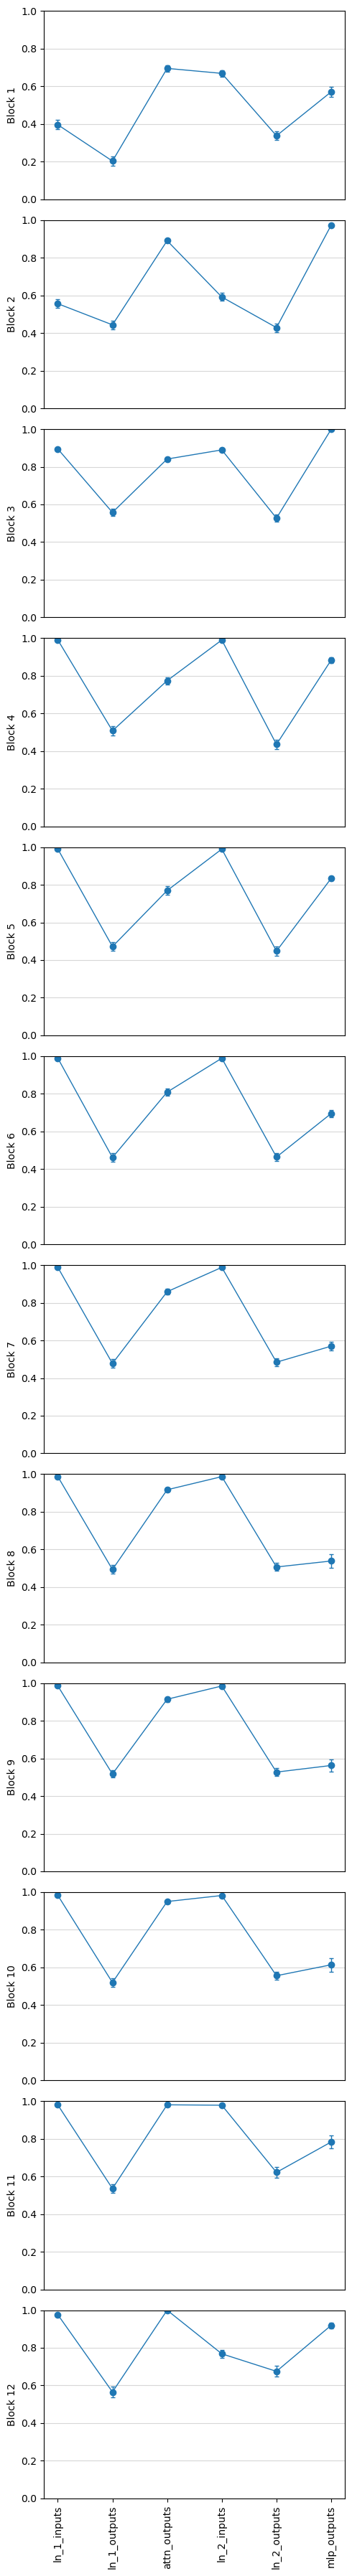

In [19]:
plot_block_information_retain(information_retain, tracked_activations)

In [13]:
information_retain[7,:,:]

array([[0.41665408, 0.54968572, 0.90751898, 0.99089891, 0.99055493,
        0.99049246, 0.98961639, 0.98836839, 0.98730022, 0.98429149,
        0.98154986, 0.9774403 ],
       [0.20867664, 0.45869565, 0.55534154, 0.50228727, 0.4520857 ,
        0.46160331, 0.47382256, 0.45165908, 0.49380147, 0.51435214,
        0.54783404, 0.55647957],
       [0.68837821, 0.88424426, 0.8548606 , 0.7677592 , 0.77048659,
        0.84654886, 0.87379611, 0.91497141, 0.90907556, 0.95550197,
        0.9830181 , 0.99983066],
       [0.6600402 , 0.59282291, 0.89854598, 0.99023849, 0.99006104,
        0.98936719, 0.98925108, 0.98789442, 0.98521781, 0.98263681,
        0.97905302, 0.73909539],
       [0.35808575, 0.42696479, 0.52686411, 0.42992938, 0.44182581,
        0.45814955, 0.4687089 , 0.50246924, 0.50951594, 0.54277897,
        0.60980409, 0.62159449],
       [0.5738312 , 0.97549766, 0.99886656, 0.89606529, 0.83941448,
        0.71626508, 0.57090539, 0.54238415, 0.55301034, 0.60607654,
        0.7642172 ,

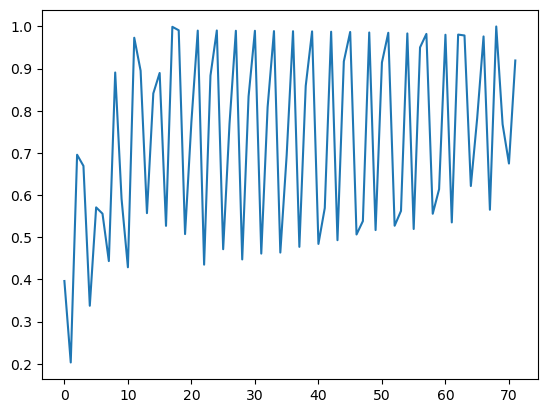

In [11]:
plt.plot(np.mean(information_retain, axis = 0).T.reshape(-1))